In [2]:
import fire
import datasets
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import os

from numina_math_dataset import extract_final_number

# Increase matplotlib font size for readability
plt.rcParams.update({'font.size': 14})


def generate_text_histogram(data, bins=50, width=80):
    """Generates a string containing a text-based histogram."""
    if not data:
        return "No data to display."

    counts, bin_edges = np.histogram(data, bins=bins)
    max_count = counts.max()
    
    hist_str = ""
    for i in range(len(counts)):
        bar_len = int((counts[i] / max_count) * (width - 25)) if max_count > 0 else 0
        bar = '█' * bar_len
        range_str = f"{bin_edges[i]:>8.2f} - {bin_edges[i+1]:<8.2f}"
        hist_str += f"{range_str} | {bar} ({counts[i]})\n"
        
    return hist_str


In [3]:
cache_dir = "/mnt/nfs_share/tikhonov/hf_cache"
num_proc = 32

# 1. Load dataset
print("Loading NuminaMath dataset...")
dataset = datasets.load_dataset(
    'PrimeIntellect/NuminaMath-QwQ-CoT-5M',
    cache_dir=cache_dir,
    split='train'
)

print(f"Dataset loaded with {len(dataset):,} examples.")

# 2. Filter for numerical answers using datasets.map for parallelism
print(f"Extracting all numerical answers using {num_proc} processes...")

# Use .map to create a new column with the extracted number
mapped_dataset = dataset.map(
    lambda example: {'number': extract_final_number(example['ground_truth'])},
    num_proc=num_proc,
    desc="Extracting numbers"
)

Loading NuminaMath dataset...


Resolving data files:   0%|          | 0/88 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/88 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/87 [00:00<?, ?it/s]

Dataset loaded with 5,138,102 examples.
Extracting all numerical answers using 32 processes...


Extracting numbers (num_proc=32):   0%|          | 0/5138102 [00:00<?, ? examples/s]

In [ ]:

print("Extracting column and filtering in memory (this should be fast)...")
all_extracted_values = mapped_dataset['number']
all_numbers = [num for num in tqdm(all_extracted_values, desc="Filtering Nones in-memory") if num is not None]


# 3. Calculate percentile bounds
lower_perc = 1.0
upper_perc = 95.0
print(f"Calculating {lower_perc}% and {upper_perc}% percentiles...")
lower_bound = np.percentile(all_numbers, lower_perc)
upper_bound = np.percentile(all_numbers, upper_perc)
print(f"Percentile bounds: lower={lower_bound:.2f}, upper={upper_bound:.2f}")

# 4. Filter out outliers
print("Filtering out outliers...")
filtered_numbers = [num for num in all_numbers if lower_bound <= num <= upper_bound]
print(f"Data after outlier removal: {len(filtered_numbers):,} examples remaining.")

# 5. Print statistics
print("\n--- Statistics of Filtered Data ---")
print(f"Count:    {len(filtered_numbers):,}")
print(f"Mean:     {np.mean(filtered_numbers):.2f}")
print(f"Std Dev:  {np.std(filtered_numbers):.2f}")
print(f"Min:      {np.min(filtered_numbers):.2f}")
print(f"25%:      {np.percentile(filtered_numbers, 25):.2f}")
print(f"Median:   {np.median(filtered_numbers):.2f}")
print(f"75%:      {np.percentile(filtered_numbers, 75):.2f}")
print(f"Max:      {np.max(filtered_numbers):.2f}")
print("-------------------------------------\n")

# 6. Generate and save graphical histogram
print("Generating graphical histogram...")
plt.figure(figsize=(14, 7))
plt.hist(filtered_numbers, bins=100, color='skyblue', edgecolor='black')
plt.title(f'Distribution of NuminaMath Answers\n(After filtering between {lower_perc}% and {upper_perc}% percentiles)')
plt.xlabel('Numerical Answer')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()
plt.close()

# 7. Generate and print text histogram
print("\n--- Text Histogram ---")
text_hist = generate_text_histogram(filtered_numbers, bins=30, width=100)
print(text_hist)


Extracting column and filtering in memory (this should be fast)...


Filtering Nones in-memory:   0%|          | 0/5138102 [00:00<?, ?it/s]

Calculating 1.0% and 95.0% percentiles...
Percentile bounds: lower=-20.00, upper=4200.00
Filtering out outliers...
Data after outlier removal: 1,787,144 examples remaining.

--- Statistics of Filtered Data ---
Count:    1,787,144
Mean:     183.73
Std Dev:  517.69
Min:      -20.00
25%:      4.00
Median:   17.00
75%:      82.00
Max:      4200.00
-------------------------------------

Generating graphical histogram...

--- Text Histogram ---
  -20.00 - 120.67   | ███████████████████████████████████████████████████████████████████████████ (1427814)
  120.67 - 261.33   | ██████ (120555)
  261.33 - 402.00   | ██ (51107)
  402.00 - 542.67   | █ (33374)
  542.67 - 683.33   | █ (20952)
  683.33 - 824.00   |  (18015)
  824.00 - 964.67   |  (13468)
  964.67 - 1105.33  |  (18220)
 1105.33 - 1246.00  |  (7747)
 1246.00 - 1386.67  |  (7502)
 1386.67 - 1527.33  |  (5830)
 1527.33 - 1668.00  |  (4152)
 1668.00 - 1808.67  |  (5217)
 1808.67 - 1949.33  |  (2997)
 1949.33 - 2090.00  |  (16248)
 2090.00 -

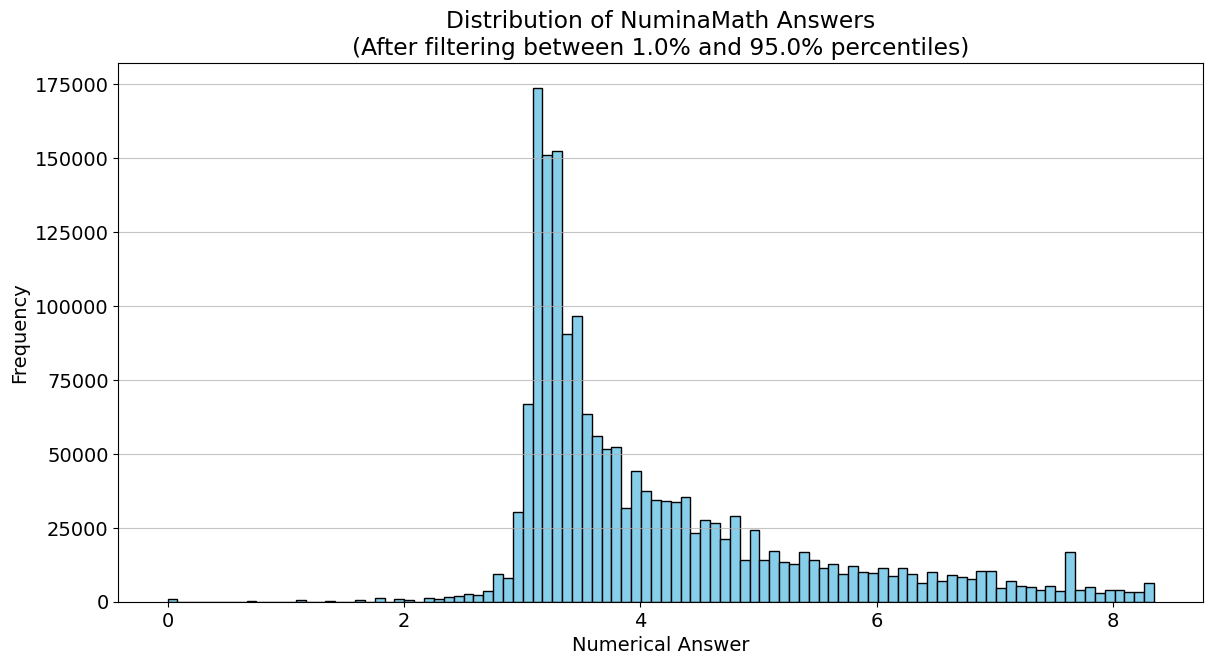

In [18]:
plt.figure(figsize=(14, 7))
plt.hist(np.log(np.array(filtered_numbers) + 21), bins=100, color='skyblue', edgecolor='black')
plt.title(f'Distribution of NuminaMath Answers\n(After filtering between {lower_perc}% and {upper_perc}% percentiles)')
plt.xlabel('Numerical Answer')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()
plt.close()

In [8]:
np.log(filtered_numbers)

/tmp/ipykernel_3424686/4054153064.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(filtered_numbers)
/tmp/ipykernel_3424686/4054153064.py:1: RuntimeWarning: invalid value encountered in log
  np.log(filtered_numbers)


array([1.38629436, 2.53844742, 5.420535  , ..., 2.89037176, 1.54700244,
       3.17805383], shape=(1787144,))

In [9]:
min_value = np.min(np.log(filtered_numbers))
max_value = np.max(np.log(filtered_numbers))
print(f"Min value: {min_value}, Max value: {max_value}")


Min value: nan, Max value: nan


/tmp/ipykernel_3424686/2412432523.py:1: RuntimeWarning: divide by zero encountered in log
  min_value = np.min(np.log(filtered_numbers))
/tmp/ipykernel_3424686/2412432523.py:1: RuntimeWarning: invalid value encountered in log
  min_value = np.min(np.log(filtered_numbers))
/tmp/ipykernel_3424686/2412432523.py:2: RuntimeWarning: divide by zero encountered in log
  max_value = np.max(np.log(filtered_numbers))
/tmp/ipykernel_3424686/2412432523.py:2: RuntimeWarning: invalid value encountered in log
  max_value = np.max(np.log(filtered_numbers))


In [13]:
np.log(5)

np.float64(1.6094379124341003)